# Solve *Easy21* by Tabular Montecarlo Control

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

sns.set()
%matplotlib inline

In [3]:
from plot_utils import draw_heatmap
from easy21 import Easy21, HIT, STICK

## Experiment of the easy21 env

In [4]:
env = Easy21()
print(env.num_actions)

2


In [5]:
env.render()

Player: 8, Dealer: 8


In [6]:
print(env.reset())
print(env.step(HIT))
print(env.step(STICK))

(5, 2)
((6, 2), 0.0, False, {})
((6, 0), 1.0, True, {})


## Epsilon greedy policy with decay

In [7]:
def EpsilonGreedyWithDecay(decay_rate, epsilon0):
    def epsilon_greedy_with_decay(qvalues, visits):
        epsilon = epsilon0 / (1.0 + decay_rate * sum(visits))
        n_actions = len(qvalues)
        probs = [epsilon / n_actions] * n_actions
        maxidx = qvalues.index(max(qvalues))
        probs[maxidx] += (1 - epsilon)
        return probs
    return epsilon_greedy_with_decay

In [8]:
explore_policy = EpsilonGreedyWithDecay(0.01, 1.0)

## Step size with decay

In [9]:
def StepSizeWithDecay(decay_rate, alpha0):
    def step_size_with_decay(visit, *args, **kwargs):
        return alpha0 / (1.0 + decay_rate * visit)
    return step_size_with_decay    

In [10]:
stepsize = StepSizeWithDecay(1.0, 1.0)

## Monte carlo control algorithm

Monte carlo control algorithm is as follows.

1. Initialize Q function.
2. Play the game with exploration policy and obtain the history of $\{(s_t, a_t, r_{t+1})\}_{t=1}^{T}$.
3. For each $t$, update the Q function by
$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \cdot \left( G_t - Q(s_t, a_t) \right),$$
where $G_t \equiv \sum_{\tau=t+1}^{T} \gamma^{\tau-t} r_{\tau}$
4. Finish if maximum number of iteration has reached, otherwise go to 2.

We will update backward at the step 3 so that we can calculate $G_t$ recursively.

In [11]:
# Here, we use dict structure for Q-values, and visit counts.
# This way, we can look up the values using the state itself as the key.
# Perhaps more efficient way is to use numpy array,
# with some effort to match states and index.

def _episode(qs, ns, env, policy):
    s = env.reset()

    history = []
    while True:
        if s not in qs:
            qs[s] = [0.0] * env.num_actions
            ns[s] = [0.0] * env.num_actions

        # pick an action by epsilon greedy
        prob = policy(qs[s], ns[s])
        action = random.choices(range(env.num_actions), prob)[0]

        s1, r, done, _ = env.step(action)
        history.append((s, action, r, done))
        if done:
            break
        s = s1
    return history

def _update(qs, ns, history, stepsize, gamma=1.0):
    g = 0.0
    for s, a, r, d in reversed(history):
        g = gamma*g + r
        # step size
        alpha = stepsize(ns[s][a])
        delta = g - qs[s][a]
        qs[s][a] += alpha * delta
        
        # increment visit count
        ns[s][a] += 1.0

In [12]:
qs = {}
ns = {}

In [13]:
for i in tqdm(range(10**6)):
    history = _episode(qs, ns, env, explore_policy)
    _update(qs, ns, history, stepsize)

In [14]:
def to_state_value(qs):
    v = np.zeros((21, 10))
    for s, q in qs.items():
        player, dealer = s
        v[player-1, dealer-1] = max(q)
    return v

def to_policy(qs):
    policy = np.zeros((21, 10), dtype=int)
    for s, q in qs.items():
        player, dealer = s
        policy[player-1, dealer-1] = q.index(max(q))
    return policy

def to_q_array(qs):
    q_array = np.zeros((21, 10, 2))
    for s, q in qs.items():
        player, dealer = s
        q_array[player-1, dealer-1] = q
    return q_array

def to_q_diff(qs):
    q_array = to_q_array(qs)
    return q_array[:,:,1] - q_array[:,:,0]

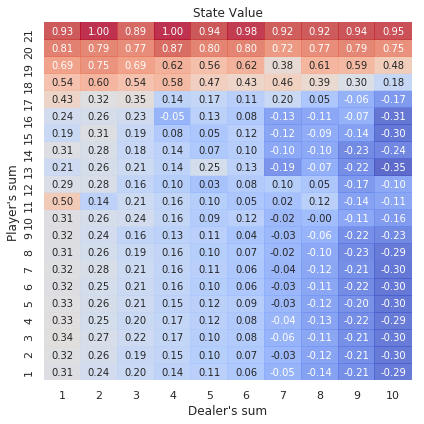

In [15]:
V = to_state_value(qs)

fig, ax = plt.subplots(figsize=(6, 6))
draw_heatmap(V, ax=ax, title="State Value")
fig.tight_layout()
None

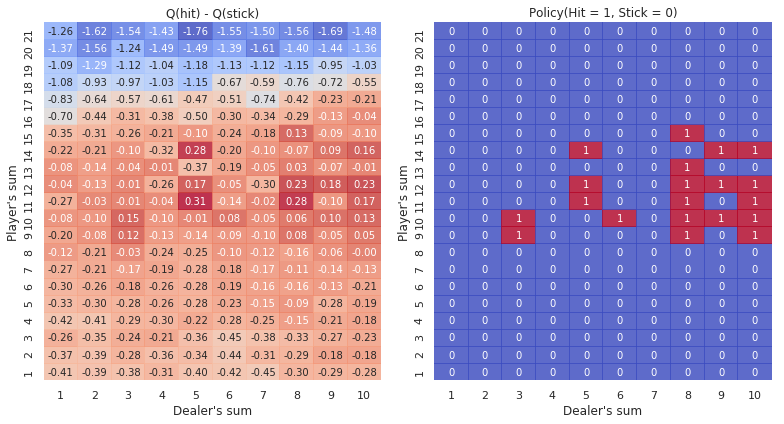

In [16]:
q_diff = to_q_diff(qs)
policy = to_policy(qs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
draw_heatmap(q_diff, ax=ax1, title="Q(hit) - Q(stick)")
draw_heatmap(policy, ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()
None

*Remark: The result is qualitatively close to the DP result, but seems still not yet converged after 10^6 iterations.*

## Comparison to the DP result

We will now compare the monte carlo control results with that of dynamic programming.
Here, we regard the DP result as "correct"; Since it has been already converged to the fixed point of the Bellman optimality equation, it is the solution (unless there is a bug in the DP implementation).

Every 1000 iteration, we will calculate the mean absolute difference between two Q-functions, and see how this "error" changes along the iterations.

In addition, we will also calculate the "correct" value of the policy via the *DP policy evaluation*. This can be important since it allows to quantify how bad the policy; Deviations of the state-value estimates does not necessarily lead to significant loss of value, depending on the problems. Concretely, we compute the state values under the derived policy using the DP technique, and then take the average across states with $player \in [1, 10]$ and $dealer \in [1, 10]$, since these are the possible initial states, occurring with equal probability.  Hence this can be seen as the expected value of the player *before* the game starts.

In [49]:
f = np.load("result/dp.npz")
Q_dp = f["Q"]
print(Q_dp.shape)

(21, 10, 2)


In [50]:
ER = f["ER"]
P = f["P"]
mean_value_dp = f["mean_value"]

# copied from the DP notebook
def evaluate_policy(policy, ER, P, gamma, V0=None, tol=1e-3):

    v = np.zeros((22*11)) if V0 is None else V0
    row_idx = np.arange(len(v))
    converged = False
    for t in range(100):
        new_v = ER[row_idx, policy] + gamma * np.matmul(P[row_idx, policy], v)
        dev = np.max(np.abs(new_v - v))
        v = new_v
        if dev < tol:
            converged = True
            break
    if not converged:
        print("WARN: policy evaluation did not converge (final deviation = %.5f)" % dev)
    return v

def mean_policy_value(policy, ER, P, gamma, V0=None, tol=1e-3):
    # add terminal states
    policy_ = np.zeros((22, 11), dtype=int)
    policy_[1:, 1:] = policy
    policy_ = policy_.flatten()
    v = evaluate_policy(policy_, ER, P, gamma, V0, tol)
    v = v.reshape((22, 11))
    return np.mean(v[1:11, 1:11])

In [36]:
mean_policy_value(policy, ER, P, gamma=1.0)

0.053008617951129905

In [28]:
policy.shape

(21, 10)

In [44]:
qs = {}
ns = {}
maes = []
values = []

In [55]:
for i in tqdm(range(10**6)):
    history = _episode(qs, ns, env, explore_policy)
    _update(qs, ns, history, stepsize)
    if (i + 1) % 1000 == 0:
        q_array = to_q_array(qs)
        maes.append(np.mean(np.abs(q_array - Q_dp)))
        values.append(mean_policy_value(to_policy(qs), ER, P, gamma=1.0))

Final error = 0.08898843493774143
Final value = 0.05268673881683763


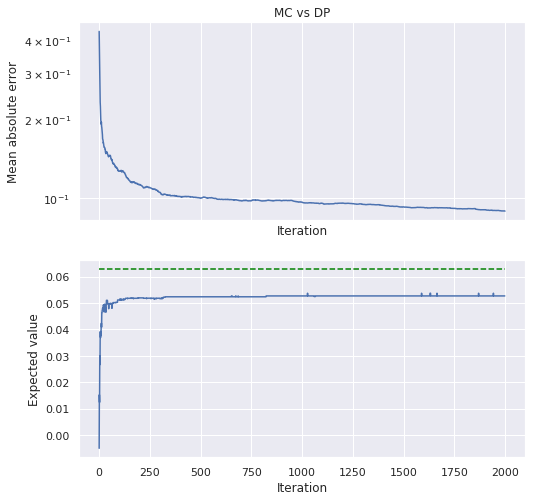

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax1.plot(maes)
ax1.set_yscale("log")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Mean absolute error")
ax1.set_title("MC vs DP")

ax2.plot(values)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Expected value")
ax2.hlines(mean_value_dp, 0, len(values), linestyles="--", color="green")
print("Final error =", maes[-1])
print("Final value =", values[-1])

*Remark: The "error" is decreasing along the iteration, but it seems there still is a long way until complete convergence.*

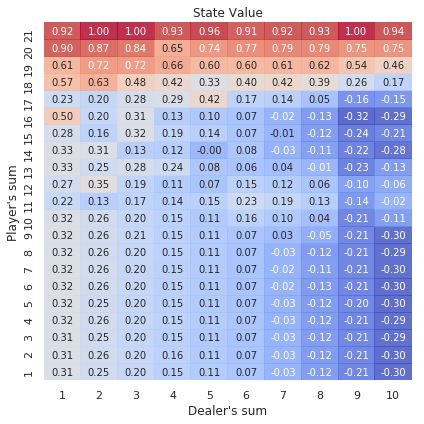

In [20]:
V = to_state_value(qs)

fig, ax = plt.subplots(figsize=(6, 6))
draw_heatmap(V, ax=ax, title="State Value")
fig.tight_layout()
None

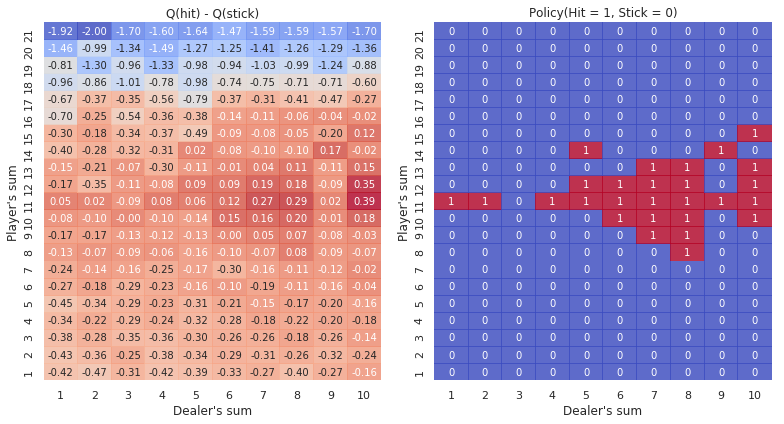

In [21]:
q_diff = to_q_diff(qs)
policy = to_policy(qs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
draw_heatmap(q_diff, ax=ax1, title="Q(hit) - Q(stick)")
draw_heatmap(policy, ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()
None